# Notebook Feux Danois

Dans cette partie nous éudierons un jeu de données correspondant aux feux de forets Danois entre 1980 et 1990

In [15]:
rm(list = ls())   # erase everything, start from scratch!
library(evir)
library(lubridate)
data(danish)
library(dplyr)
library(ggplot2)
library(KScorrect)
library('EnvStats')
#??date
# summary(danish)
#danish


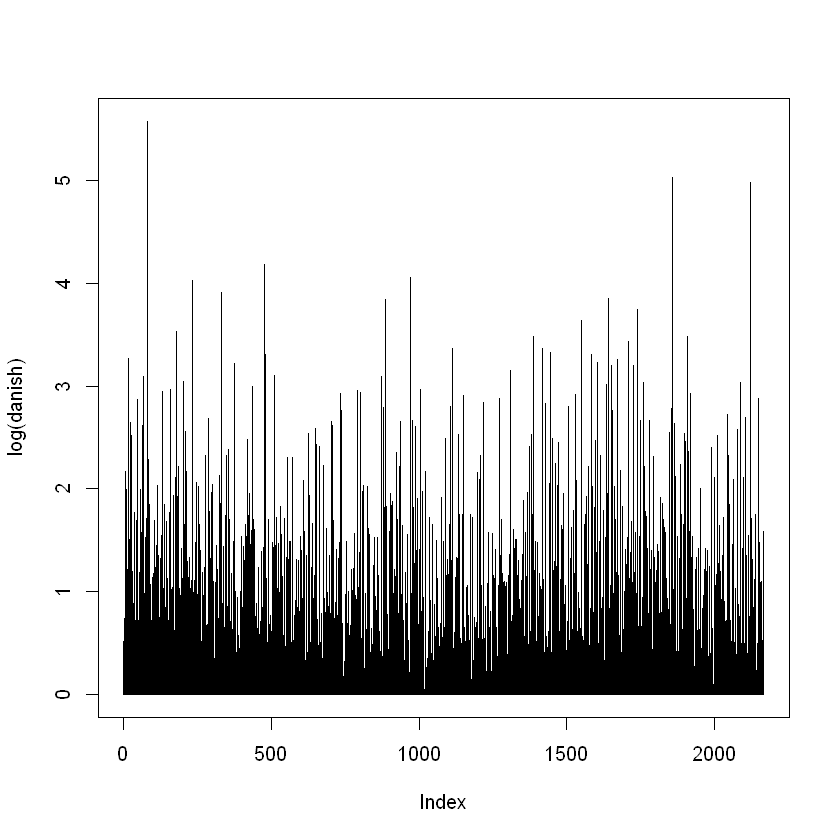

In [16]:
plot(log(danish),type ="h")

In [17]:
temps=attributes(danish)$times
df= data.frame (danish)
time.interval <- temps[0:2166] %--% temps[2 :  2167]

time.duration <- as.duration(time.interval)
Time= as.numeric (time.duration, "days")


In [18]:
N_T= cumsum(Time)
Lamb=length(N_T)/N_T[length(N_T)]
print (Lamb)

[1] 0.539477


Construction du dataframe pour travailler sur les données

In [19]:
df$T_i <- c(0,N_T)
df$W_i <- c(Time,0)
df$Year <- substring(temps,1,4)
head(df)

,danish,T_i,W_i,Year
,<dbl>,<dbl>,<dbl>,<chr>
1,1.683748,0,1,1980
2,2.093704,1,1,1980
3,1.732581,2,2,1980
4,1.779754,4,0,1980
5,4.612006,4,3,1980
6,8.725274,7,0,1980


In [20]:
df_annee <- df%>%
group_by(Year)%>%
summarise(Moyenne_Feux = mean(W_i),
         Lambda_Est = 1/mean(W_i),
         Nombre_Feux = n())


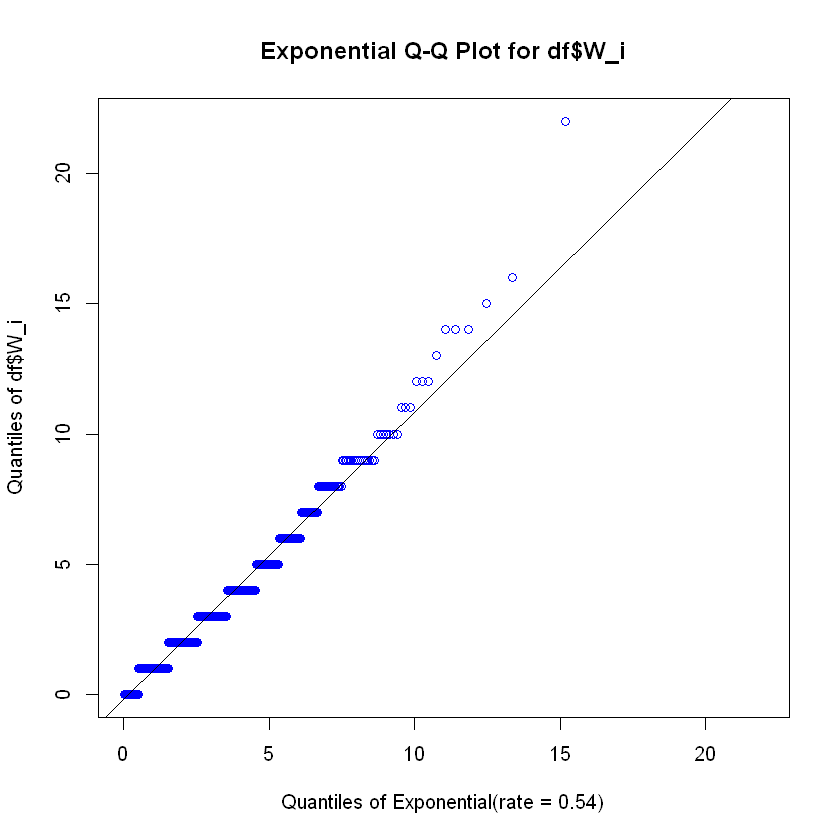

In [21]:

qqPlot(df$W_i, dist = "exp", 
      estimate.params = TRUE, digits = 2, points.col = "blue", 
      add.line = TRUE)

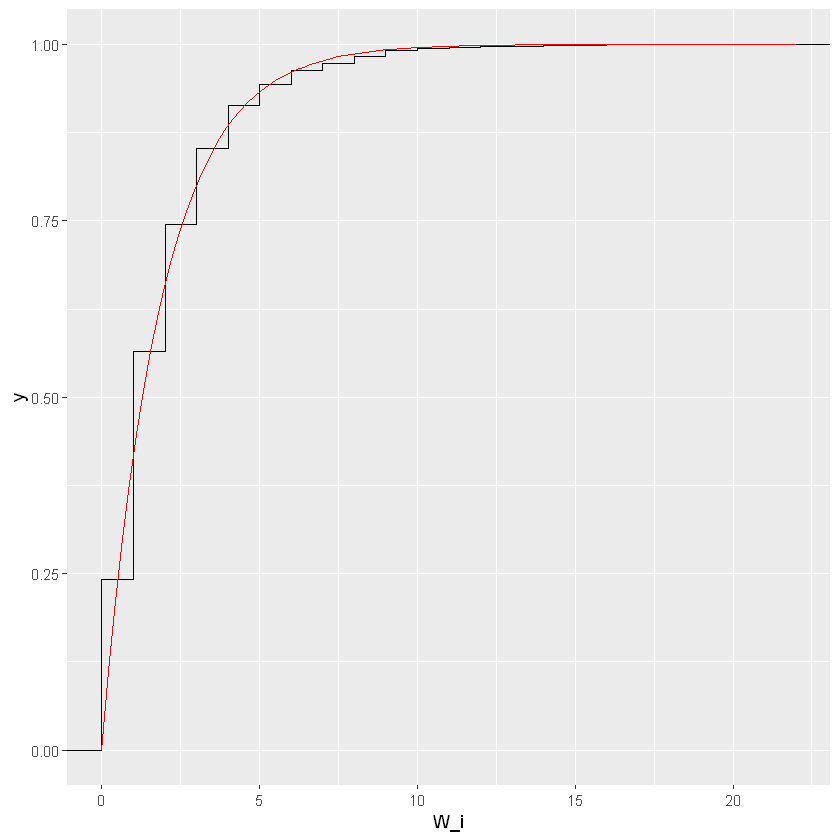

In [22]:
F1=ggplot(df, aes(W_i)) + 
  stat_ecdf(geom = "step") +
  stat_function(fun = pexp, args = (mean=Lamb), col="red")
F1

Si on suppose que le processus de comptage suit le processus de Poisson, lambda estimé par 0.5.
On a à peu près 1 claim tous les deux jours.

On veut s'assurer que ce processus suive bien une loi de Poisson. Il faut que les Wi soient des exponentielles iid de param (1/lmbda). Or on s'appersoit que le paramètre lambda ne semble pas être constant sur les 11 années !



In [23]:
df_annee

,Year,Moyenne_Feux,Lambda_Est,Nombre_Feux
,<chr>,<dbl>,<dbl>,<int>
1,1980,2.192771,0.4560440,166
2,1981,2.176471,0.4594595,170
3,1982,2.000000,0.5000000,181
4,1983,2.372549,0.4214876,153
5,1984,2.245399,0.4453552,163
6,1985,1.768116,0.5655738,207
7,1986,1.529412,0.6538462,238
8,1987,1.615044,0.6191781,226
9,1988,1.747619,0.5722071,210


### 5 premières années
Pour la suite et afin d'approximer au mieux un processus de poisson homogène nous décidons de travailler sur les 5 premières années ! 

In [24]:
d_homo <- df[which(df$Year < 1986),]
dh_annee <- d_homo%>%
group_by(Year)%>%
summarise(Moyenne_Feux = mean(W_i),
         Lambda_Est = 1/mean(W_i),
         Nombre_Feux = n())
dh_annee

,Year,Moyenne_Feux,Lambda_Est,Nombre_Feux
,<chr>,<dbl>,<dbl>,<int>
1,1980,2.192771,0.4560440,166
2,1981,2.176471,0.4594595,170
3,1982,2.000000,0.5000000,181
4,1983,2.372549,0.4214876,153
5,1984,2.245399,0.4453552,163
6,1985,1.768116,0.5655738,207


A présent nous estimons notre nouveau paramètre $\hat{\lambda}$:

In [25]:
N_T_H= cumsum(d_homo$W_i)
Lamb_h=length(N_T_H)/N_T_H[length(N_T_H)]
print (Lamb_h)

[1] 0.4746691


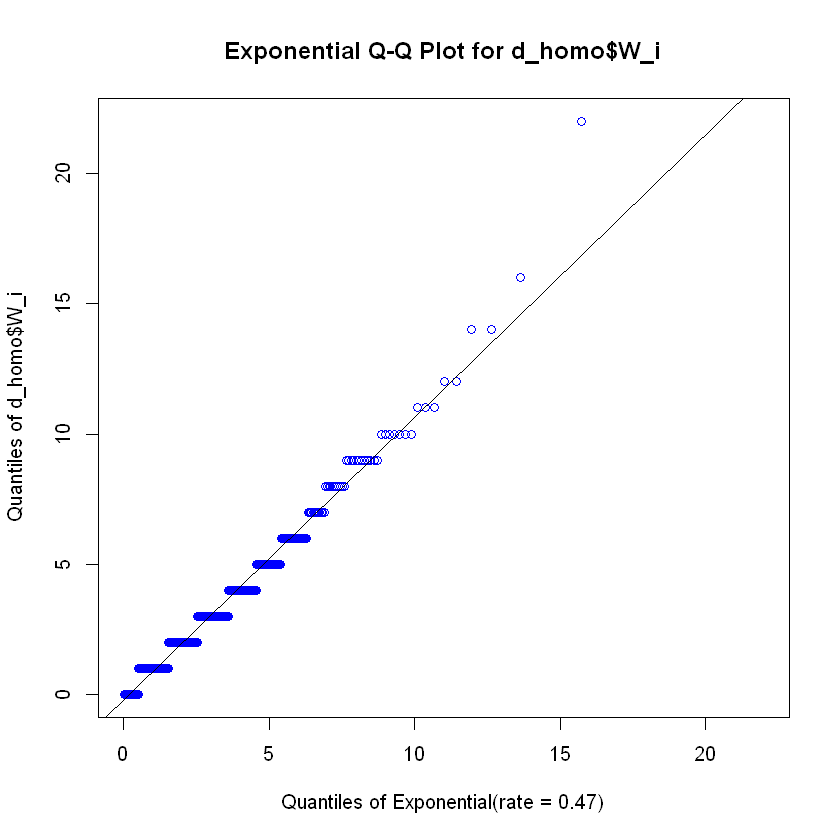

In [26]:
qqPlot(d_homo$W_i, dist = "exp", 
      estimate.params = TRUE, digits = 2, points.col = "blue", 
      add.line = TRUE)

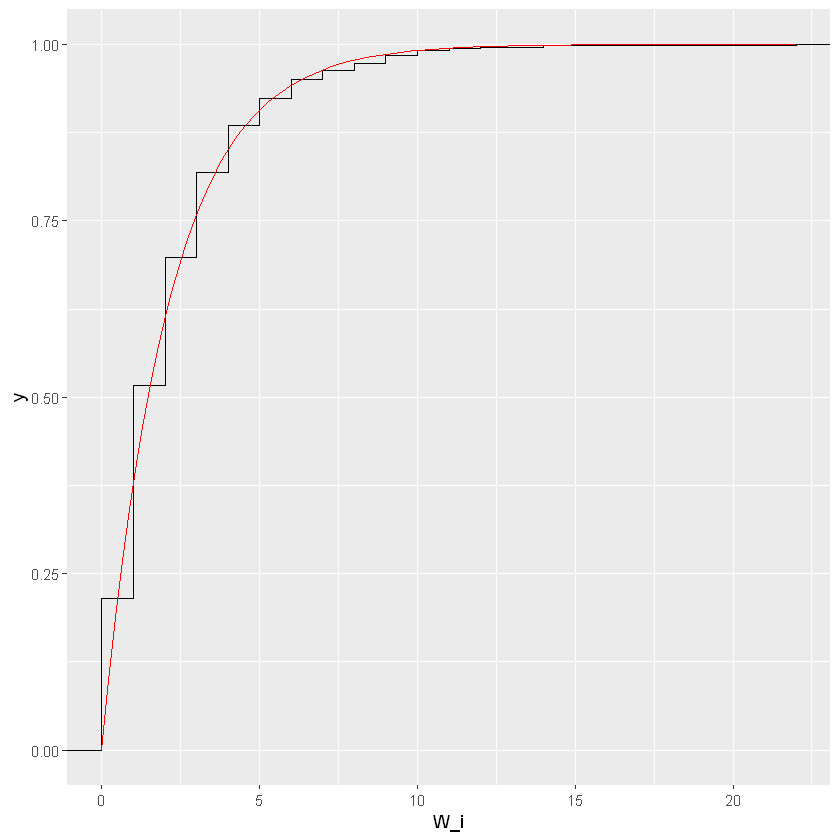

In [27]:
F1=ggplot(d_homo, aes(W_i)) + 
  stat_ecdf(geom = "step") +
  stat_function(fun = pexp, args = (mean=Lamb_h), col="red")
F1

In [29]:
library(sn)
library(ghyp)
library(MASS)
library(fitdistrplus) 

library(copula) 
library(fExtremes) 
#on test les distributions a queues lourdes

#estimer les param pour weibull et lognormal

param_weib=fitdistr(df$danish, "weibull") 
print(param_weib)

param_lnorm=fitdistr(df$danish, "lognormal") 
print(param_lnorm)

#on a exactement les mêmes paramètres que dans le doc sur internet

### Test pour fitter une loi sur les claims
ks.test(df$danish, "plnorm",meanlog = 0.78695009, sdlog = 0.71655451)
ks.test(df$danish, "pweibull",shape=0.95851611 ,scale=3.29117062)

### A ce stade là on élimine log-normal et weibull

ks.test(df$danish,"psn", location=0.9721663, scale=8.8584110, shape=1533.7683374) 
ks.test(df$danish,"pst", location=0.9999994, scale=0.8240933, shape=71916290, df=1.100162) 



Warning message:
"package 'sn' was built under R version 4.0.5"
Loading required package: stats4


Attaching package: 'sn'


The following object is masked from 'package:lubridate':

    dst


The following object is masked from 'package:stats':

    sd


Warning message:
"package 'ghyp' was built under R version 4.0.5"
Loading required package: numDeriv

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:EnvStats':

    boxcox


The following object is masked from 'package:dplyr':

    select


Warning message:
"package 'fitdistrplus' was built under R version 4.0.5"
Loading required package: survival

Warning message:
"package 'copula' was built under R version 4.0.5"

Attaching package: 'copula'


The following object is masked from 'package:EnvStats':

    ebeta


The following object is masked from 'package:lubridate':

    interval


Warning message:
"package 'fExtremes' was built under R version 4.0.5"
Loading required packa

     shape        scale   
  0.95851611   3.29117062 
 (0.01221576) (0.07848660)
    meanlog       sdlog   
  0.78695009   0.71655451 
 (0.01539288) (0.01088441)


Warning message in ks.test(df$danish, "plnorm", meanlog = 0.78695009, sdlog = 0.71655451):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  df$danish
D = 0.13746, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(df$danish, "pweibull", shape = 0.95851611, scale = 3.29117062):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  df$danish
D = 0.2733, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(df$danish, "psn", location = 0.9721663, scale = 8.858411, :
"ties should not be present for the Kolmogorov-Smirnov test"


ERROR: Error in T.Owen(z, alpha, ...): arguments inutilisés (location = 0.9721663, scale = 8.858411, shape = 1533.7683374)


In [ ]:

Lc <- LcKS(d_homo$W_i+0.0000000001,cdf="pexp",nreps=999)
Lc$p.value

In [ ]:
a<-rnorm(length(d_homo$W_i),mean=0,sd=0.00000001)
head(a)
ks.test(d_homo$W_i+a, "pexp", Lamb_h)

Sur le quatres premières années ? 

In [ ]:
d_homo2 <- df[which(df$Year < 1985),]
dh2_annee <- d_homo2%>%
group_by(Year)%>%
summarise(Moyenne_Feux = mean(W_i),
         Lambda_Est = 1/mean(W_i),
         Nombre_Feux = n())
dh2_annee

In [ ]:
N_T_H2= cumsum(d_homo2$W_i)
Lamb_h2=length(N_T_H2)/N_T_H2[length(N_T_H2)]
print (Lamb_h2)

In [ ]:
Lc <- LcKS(d_homo2$W_i+0.0000000001,cdf="pexp",nreps=999)
Lc$p.value

In [ ]:
qqPlot(d_homo2$W_i, dist = "exp", 
      estimate.params = TRUE, digits = 2, points.col = "blue", 
      add.line = TRUE)

In [ ]:
F1=ggplot(d_homo2, aes(W_i)) + 
  stat_ecdf(geom = "step") +
  stat_function(fun = pexp, args = (mean=Lamb_h2), col="red")
F1

### Test sur la loi des W_t : sur tout le jeux de données

In [ ]:
#Code pas très optimal mais permets de créer des Wt ou il n'y a plus de zéro

N=length (Time)
Time2=Time
for (i in (2:N-1)){
      if (Time[i]==0 & Time [i+1]!=0 )
      {Time2[i]=0.5} 
    else if (Time[i]==0 & Time [i+1]==0 )
    {Time2[i]=0.3
        Time2[i+1]=0.3}  
}

In [ ]:
# Les test avec Time 2: Ks test ne change pas LcKs un peu meilleur mais reste petit (0.001)




Lc <- LcKS(Time2,cdf="pexp",nreps=999)
Lc$p.value

In [ ]:
mu1= mean (Time) #pour s'assurer qu'on retrouve bien Lamb=1/mu1

ks.test(Time,"pexp",1/mu1)
#ks.exp.test(Time)#,"pexp",lambda=1/mu1)

In [ ]:
###  Methode en affichant la fdr empirique

plot(ecdf(Time), main = "Méthode de la fonction de répartition")
curve(pexp(x, 1/mu1), add = TRUE)


In [ ]:
###  Version en affichant les histogrammes empirique
hist(Time, freq = FALSE, main = "Méthode de l’histogramme", ylab = "")
curve(dexp(x, 1/mu1), add = TRUE)

On analyse le processus de poisson associé aux données Danish Fire afin de s'assurer que notre processus est homogène !

Sous les hyothèses que les que $W_i$ sont iid et suivent un processus $Exp(\lambda)$ nous pouvons estimer $\widehat{\lambda}=0.54$

On est dans le cas Large claims, on commence par observer les données et estimer lambda

In [ ]:
boxplot(log(danish),main="Boxplot des différents claims",outline=FALSE) #j'applique le log sur les claims
#Calcul de la moyenne et ecart type de X
mu=mean(danish)
sigma= sd(danish)


In [ ]:
###  Il y'a possibilté de génerer directement le modèle CL avec le packge ruin
library(ruin)


model <- CramerLundberg(initial_capital = 10,
premium_rate = 2,
claim_poisson_arrival_rate = Lamb,
claim_size_generator = rexp,
claim_size_parameters = list(rate = 1))
path <- simulate_path(model = model, max_time_horizon = 100)
plot_path(path)